#**Multiclass Text Classification**

**Data source:** Bureau of Consumer Financial Protection (dataset is intended for public access and use)
**Dataset name:** Consumer Complaint Database
**Link:** https://catalog.data.gov/dataset/consumer-complaint-database
**Goal:** Assign a new complain to one of known categories.

Dataset was reduced for illustration purpose.

In [0]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.0.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

#**Load and clean data**

In [0]:
!ls

for_RNN.csv  sample_data


In [0]:
#load data
df_data = pd.read_csv('for_RNN.csv', encoding='ISO-8859-1')

print('Length of the initial dataset:', len(df_data))
df_data.head(1).T

Length of the initial dataset: 447914


,0
Unnamed: 0,203
Product,"Credit reporting, credit repair services, or o..."
Consumer complaint narrative,After reviewing my reports. I noticed several ...


In [0]:
# labels (product categories) 
df_data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    123831
Debt collection                                                                  98476
Mortgage                                                                         58139
Credit reporting                                                                 31588
Credit card or prepaid card                                                      27658
Student loan                                                                     23824
Credit card                                                                      18838
Checking or savings account                                                      16653
Bank account or service                                                          14885
Consumer Loan                                                                     9473
Vehicle loan or lease                                                             7169
Money transfer, virtual currency, or money 

In [0]:
# making "Credit reporting, credit repair services, or other personal consumer reports" and 
# "Credit reporting" as one category "Personal consumer reports"

df_data['Product'] = df_data['Product'].str.replace("Credit reporting, credit repair services, or other personal consumer reports", 
                                                    "Personal consumer reports")
df_data['Product'] = df_data['Product'].str.replace("Credit reporting", 
                                                    "Personal consumer reports")

In [0]:
# labels (product categories) 
df_data['Product'].value_counts()

Personal consumer reports                             155419
Debt collection                                        98476
Mortgage                                               58139
Credit card or prepaid card                            27658
Student loan                                           23824
Credit card                                            18838
Checking or savings account                            16653
Bank account or service                                14885
Consumer Loan                                           9473
Vehicle loan or lease                                   7169
Money transfer, virtual currency, or money service      6848
Payday loan, title loan, or personal loan               5530
Payday loan                                             1747
Money transfers                                         1497
Prepaid card                                            1450
Other financial service                                  292
Virtual currency        

##### **Just for the illustration:**
only 20000 of random observations from top 4 product categories are selected
8000 for model training/testing and 2000 for model evaluation on unseen data

In [0]:
# selecting only top 4 product categories 
selected_products= ["Personal consumer reports",
                   "Debt collection",
                   "Mortgage",
                   "Credit card or prepaid card"]

In [0]:
# selecting 600 random records of each type of selected products
df_train_list = []
df_test_list = []

for product in selected_products:
    df_tmp = df_data[df_data['Product'] == product].sample(n=25000, random_state=1)
    df_train_list.append(df_tmp.iloc[2000:])
    df_test_list.append(df_tmp.iloc[:2000])

df = pd.concat(df_train_list) 
df_test = pd.concat(df_test_list) 

print('TRAIN Dataset length:', len(df))
print('\nComplain categories and counts:')
print(df['Product'].value_counts())

print('\n\nEVALUATION Dataset length:', len(df_test))
print('\nComplain categories and counts:')
print(df_test['Product'].value_counts())

TRAIN Dataset length: 92000

Complain categories and counts:
Credit card or prepaid card    23000
Personal consumer reports      23000
Debt collection                23000
Mortgage                       23000
Name: Product, dtype: int64


EVALUATION Dataset length: 8000

Complain categories and counts:
Mortgage                       2000
Credit card or prepaid card    2000
Debt collection                2000
Personal consumer reports      2000
Name: Product, dtype: int64


#**Prepare data for training and testing a model**

In [0]:
# turning labels into numbers
LE = LabelEncoder()
df['Product_num'] = LE.fit_transform(df['Product'])
df_test['Product_num'] = LE.transform(df_test['Product'])

ts_tmp = df.groupby('Product')['Product_num'].min()
dict_product_id = ts_tmp.to_dict()
pd.DataFrame(ts_tmp) 

,Product_num
Product,
Credit card or prepaid card,0
Debt collection,1
Mortgage,2
Personal consumer reports,3


In [0]:
ts_tmp = df_test.groupby('Product')['Product_num'].min()
pd.DataFrame(ts_tmp)

,Product_num
Product,
Credit card or prepaid card,0
Debt collection,1
Mortgage,2
Personal consumer reports,3


In [0]:
# data for model train/evaluate
X = df['Consumer complaint narrative']
Y = df['Product_num']

X_test = df_test['Consumer complaint narrative']
Y_test = df_test['Product_num']

In [0]:
# split up the data
seed = 100
val_size = 0.3

#split dataset into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, 
                                                    test_size=val_size, 
                                                    random_state=seed)

In [0]:
X_train.iloc[::200]

159240    I failed to receive statements from Well Fargo...
156338    I've been a user of Citibank XXXX XXXX credit ...
363326    XXXX claims they are collecting a debt and or ...
386717    Since I have n't had debt to anyone for over t...
322244    I mailed a letter XXXX requesting debt validat...
                                ...                        
103357    I have disputed the late payments on this XXXX...
43970     Contacted bureau to investigate incorrect acco...
130221    XXXX  is reporting a debt that is fraudulent. ...
92943     XXXX XXXX XXXX  XXXX XXXX XXXX XXXX  XXXX, MN ...
96445     I disputed an Americollect account that is rep...
Name: Consumer complaint narrative, Length: 322, dtype: object

In [0]:
y_train.iloc[::200]

159240    0
156338    0
363326    1
386717    1
322244    1
         ..
103357    3
43970     3
130221    3
92943     3
96445     3
Name: Product_num, Length: 322, dtype: int64

#**Build Deep Learning model (Embeding+LSTM+MaxPooling)**

In [0]:
# convert sentences to sequences

#Tolkeniser 
# converts each sentence into list of tokens
# converts list of tokens into the list of integers where each integer corresponds to a word in the BofW disctionary

MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

# train tolkeniser on X_train (tolkenise, build BoW dictionary, word2index)
tokenizer.fit_on_texts(X_train)

# sentence2list:
# get lists of indexies for each token in each sentence in df_train and df_test based on BoW dictionary from train
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [0]:
ind=9

print('Result of Tolkeniser preprocessing is list of lists of indexies', type(sequences_train))
print('\nExample:\n',X_train.iloc[ind],'\n\nIs transfromed to:')
sequences_train[ind]

Result of Tolkeniser preprocessing is list of lists of indexies <class 'list'>

Example:
 I need to get my name straight on my credit report. XXXX XXXX XXXX is my name please remove any other name from my credit report it is not accurate. I have only one employer XXXX. please remove any other employer from my report they are not accurate. I have a few unverified account I am not sure how they showed up on my report never done business with these companies?? Please forward me the proper verification this is the third time I have complained about this accounts on my credit report it is not accurate and was never verified according to the FCRA guidelines 623,611 please remove the following account they are not accurate : XXXX XXXX XXXX # XXXX, XXXX XXXX  # XXXX, XXXX XXXX XXXX  # XXXX, XXXX & XXXX XXXX XXXX XXXX XXXX # XXXX XXXX XXXX XXXX XXXX  # XXXX 

Is transfromed to:


[3,
 172,
 4,
 85,
 7,
 139,
 2378,
 13,
 7,
 22,
 47,
 1,
 1,
 1,
 19,
 7,
 139,
 130,
 228,
 54,
 132,
 139,
 24,
 7,
 22,
 47,
 23,
 19,
 16,
 663,
 3,
 18,
 104,
 79,
 1224,
 1,
 130,
 228,
 54,
 132,
 1224,
 24,
 7,
 47,
 14,
 38,
 16,
 663,
 3,
 18,
 6,
 437,
 1222,
 25,
 3,
 62,
 16,
 470,
 154,
 14,
 748,
 86,
 13,
 7,
 47,
 67,
 257,
 205,
 21,
 113,
 409,
 130,
 715,
 20,
 2,
 815,
 489,
 15,
 19,
 2,
 582,
 63,
 3,
 18,
 1811,
 92,
 15,
 129,
 13,
 7,
 22,
 47,
 23,
 19,
 16,
 663,
 5,
 11,
 67,
 426,
 555,
 4,
 2,
 458,
 1209,
 1745,
 1516,
 130,
 228,
 2,
 341,
 25,
 14,
 38,
 16,
 663,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

Most sentences have less than 500 tokens:


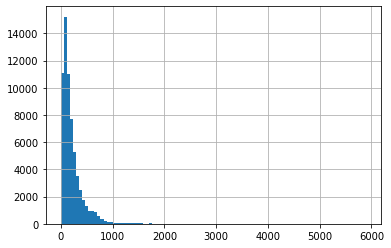

In [0]:
# look at the distribution of sentence token counts in X_train
ts = pd.Series([len(s) for s in sequences_train])
ts.hist(bins=100)
print('Most sentences have less than 500 tokens:')

Hence T=500 is a good candidate for maximum length of the sentence for RNN.

In the Tensor RNN data should be NxTxD array 
where 
- N is size of the data (number of texts)
- T is maximum sequence length
- D is number of features (embedding dimensionality)


In [0]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens (vocabulary length).' % V)

Found 49931 unique tokens (vocabulary length).


In [0]:
# pad sequences so that we get a N x T matrix
T = 500
data_train = pad_sequences(sequences=sequences_train,
                           maxlen=T,
                           padding='pre',
                           truncating='post',
                           value=0
                           )
print('Shape of data train tensor:', data_train.shape)

Shape of data train tensor: (64400, 500)


In [0]:
data_val = pad_sequences(sequences=sequences_val,
                           maxlen=T,
                           padding='pre',
                           truncating='post',
                           value=0
                           )
print('Shape of data test tensor:', data_val.shape)

Shape of data test tensor: (27600, 500)


In [0]:
data_test = pad_sequences(sequences=sequences_test,
                           maxlen=T,
                           padding='pre',
                           truncating='post',
                           value=0
                           )
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (8000, 500)


In [0]:
# create the model

# embedding dimensionality
D = 20

# hidden state dimensionality
M = 10

###### Construct the Model ###########
i = Input(shape=(T,))

x = Embedding(V + 1, D)(i) 
x = LSTM(M, return_sequences=True)(x) 
x = GlobalMaxPooling1D()(x) 
x = Dense(4, activation='softmax')(x) #labels should start from 0

###### Compile the Model ###########
model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 20)           998640    
_________________________________________________________________
lstm (LSTM)                  (None, 500, 10)           1240      
_________________________________________________________________
global_max_pooling1d (Global (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 44        
Total params: 999,924
Trainable params: 999,924
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile and fit
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  y_train.values,
  epochs=3,
  validation_data=(data_val, y_val.values)
)

Training model...
Train on 64400 samples, validate on 27600 samples
Epoch 1/3
64400/64400 [==============================] - 196s 3ms/sample - loss: 0.6297 - accuracy: 0.7647 - val_loss: 0.3934 - val_accuracy: 0.8676
Epoch 2/3
64400/64400 [==============================] - 188s 3ms/sample - loss: 0.3404 - accuracy: 0.8863 - val_loss: 0.3330 - val_accuracy: 0.8878
Epoch 3/3
64400/64400 [==============================] - 187s 3ms/sample - loss: 0.2825 - accuracy: 0.9054 - val_loss: 0.3224 - val_accuracy: 0.8916


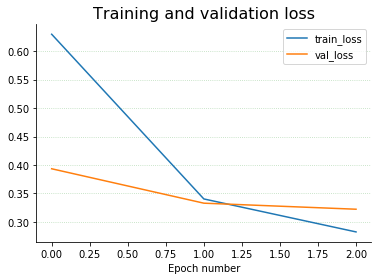

In [0]:
# plot loss per iteration
#https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error
ax = plt.subplot(111)
ax.plot(r.history['loss'], label='train_loss')
ax.plot(r.history['val_loss'], label='val_loss')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('Training and validation loss',fontsize=16)
plt.xlabel('Epoch number')
plt.grid(axis='y',color='g', alpha=0.3, linestyle=':')
plt.legend()

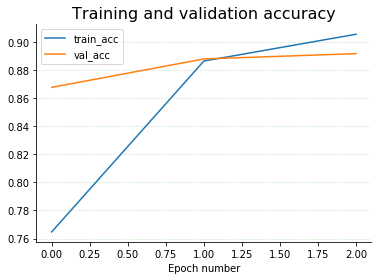

In [0]:
# plot accuracy per iteration
ax = plt.subplot(111)
ax.plot(r.history['accuracy'], label='train_acc')
ax.plot(r.history['val_accuracy'], label='val_acc')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('Training and validation accuracy',fontsize=16)
plt.xlabel('Epoch number')
plt.grid(axis='y',color='g', alpha=0.3, linestyle=':')
plt.legend()

In [0]:
y_pred_prob = model.predict(data_test)
y_pred_prob.shape

(8000, 4)

In [0]:
y_pred_prob

array([[1.8217376e-02, 4.2414716e-01, 2.5218423e-03, 5.5511361e-01],
       [8.1919897e-03, 1.0094382e-02, 2.5271479e-04, 9.8146087e-01],
       [1.1011400e-03, 8.7356130e-03, 5.5562245e-04, 9.8960763e-01],
       ...,
       [9.9503160e-01, 4.8587727e-04, 1.3392549e-03, 3.1432691e-03],
       [9.9561501e-01, 1.2875585e-03, 1.1872884e-03, 1.9102209e-03],
       [9.8710084e-01, 1.5788859e-03, 2.9181689e-03, 8.4020430e-03]],
      dtype=float32)

In [0]:
y_pred = np.argmax(y_pred_prob, axis=1)

In [0]:
y_pred

array([3, 3, 3, ..., 0, 0, 0])

In [0]:
#model evaluation
score = accuracy_score(Y_test, y_pred)
f_score = f1_score(Y_test, y_pred, average='micro')
print("The accuracy score (NN) is:", score)
print("The F score-Micro (NN) is:", f_score)

The accuracy score (NN) is: 0.896375
The F score-Micro (NN) is: 0.896375


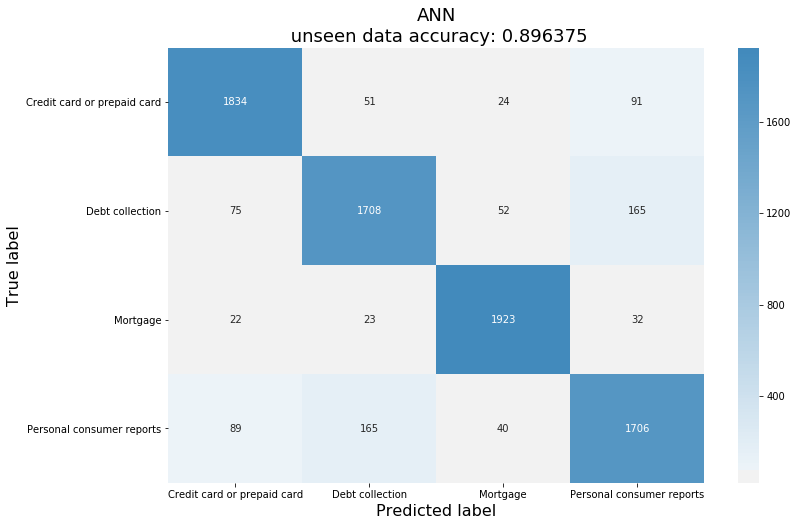

In [0]:
# confusion matrix
cm = confusion_matrix(Y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['Credit card or prepaid card',
                              'Debt collection','Mortgage', 
                              'Personal consumer reports'],                      
                     columns = ['Credit card or prepaid card',
                              'Debt collection','Mortgage', 
                              'Personal consumer reports'])

# plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(10, 240, s=80, l=55, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('ANN\n unseen data accuracy: ' + str(accuracy_score(Y_test, y_pred)), fontsize = 18)
plt.ylabel('True label', fontsize = 16)
plt.xlabel('Predicted label', fontsize = 16)
plt.show()